<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Diffusion-equation" data-toc-modified-id="Diffusion-equation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Diffusion equation</a></span></li><li><span><a href="#implementations" data-toc-modified-id="implementations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>implementations</a></span><ul class="toc-item"><li><span><a href="#Python:-explicit-[]" data-toc-modified-id="Python:-explicit-[]-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Python: explicit <code>[]</code></a></span></li><li><span><a href="#Numpy" data-toc-modified-id="Numpy-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Numpy</a></span></li><li><span><a href="#Numba" data-toc-modified-id="Numba-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Numba</a></span></li><li><span><a href="#Cyton:-exact-python" data-toc-modified-id="Cyton:-exact-python-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Cyton: exact python</a></span></li><li><span><a href="#Cyton:-with-type-annotation" data-toc-modified-id="Cyton:-with-type-annotation-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Cyton: with type annotation</a></span></li><li><span><a href="#Cython:-optimized-for-strides" data-toc-modified-id="Cython:-optimized-for-strides-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Cython: optimized for strides</a></span></li><li><span><a href="#Cython:-C" data-toc-modified-id="Cython:-C-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Cython: C</a></span></li><li><span><a href="#C/C++" data-toc-modified-id="C/C++-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>C/C++</a></span><ul class="toc-item"><li><span><a href="#Compile-and-run" data-toc-modified-id="Compile-and-run-2.8.1"><span class="toc-item-num">2.8.1&nbsp;&nbsp;</span>Compile and run</a></span></li></ul></li></ul></li><li><span><a href="#Have-a-break:-Visualization-of-the-temperature" data-toc-modified-id="Have-a-break:-Visualization-of-the-temperature-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Have a break: Visualization of the temperature</a></span></li><li><span><a href="#Test-speed" data-toc-modified-id="Test-speed-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test speed</a></span></li></ul></div>

# Diffusion equation

Stationary diffusion equation
$$\frac{\partial^2 \phi}{\partial^2 x} + \frac{\partial^2 \phi}{\partial^2 y} = -\rho$$
where the $\rho$ is the source, $\phi$ is the density.

In the heat transfer example, the heat source is the source, and the temperature is the "heat density".

We can descrese the equation as
$$
\frac{\phi(x+\Delta x,y) + \phi(x-\Delta x,y) + \phi(x,y+\Delta x) + \phi(x,y-\Delta x) - 4\phi(x,y)}{(\Delta x) ^2} =  -\rho
$$
where $\Delta x = \Delta y$
Then we can write down the iteration equation
$$
\phi(x,y) = \frac{\phi(x+\Delta x,y) + \phi(x-\Delta x,y) + \phi(x,y+\Delta x) + \phi(x,y-\Delta x)}{4} + (\Delta x) ^2 \rho
$$

# implementations

In [1]:
import sys
print(sys.version)

3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]


## Python: explicit `[]`

In [2]:
#%%writefile temp.py
import numpy as np


def temperature_python(phi, rho, alpha, dx, n_iter):
    # phi[0,:] the left boundary, not update
    # phi[phi.shape[0]-1,:] the right boundary, not update
    # phi[0,:] the left boundary, not update
    # phi[:,phi.shape[1]-1] the top boundary, not update

    # a buffer is needed
    # we don't want to refer the updated result
    # when we write e.g. phi[i-1,j]
    phi_update = np.empty_like(phi)
    for it in range(n_iter):
        for i in range(1, phi.shape[0] - 1):
            for j in range(1, phi.shape[1] - 1):
                phi_update[i, j] = 0.25 * (phi[i - 1,j] + phi[i + 1,j]\
                    + phi[i, j - 1] + phi[i, j + 1])\
                    + dx**2 * rho[i, j]

        for i in range(1, phi.shape[0] - 1):
            for j in range(1, phi.shape[1] - 1):
                phi[i, j] = phi_update[i, j]

## Numpy

In [3]:
def temperature_numpy(phi, rho, alpha, dx, n_iter):

    M = phi.shape[0]
    N = phi.shape[1]
    rho = dx**2 * rho[1:M - 1, 1:N - 1]
    for _ in range(n_iter):
        phi[1:M - 1, 1:N - 1] = 0.25*(phi[0:M - 2, 1:N - 1]\
            + phi[2:M, 1:N - 1]\
            + phi[1:M-1, 0:N - 2]\
            + phi[1:M-1, 2:N])\
            + rho

## Numba

In [4]:
import numba as nb
#parallel=True not work in this case
temperature_numba = nb.jit(nopython=True)(temperature_python)
temperature_numba_numpy = nb.jit(nopython=True)(temperature_numpy)

## Cyton: exact python

In [5]:
# please install cython
# >>> conda install cython
%load_ext cython

We compile the python to C code. The only optimization is avoiding the reading the bytecode and parsing. Because, in this mode, we still use CPython runtime and the CPython runtime is the slowest part. We except there is no acceleration.

In [6]:
%%cython
#%load temp.py
import numpy as np

def temperature_cython_python(phi, rho, alpha, dx, n_iter):
    # phi[0,:] the left boundary, not update
    # phi[phi.shape[0]-1,:] the right boundary, not update
    # phi[0,:] the left boundary, not update
    # phi[:,phi.shape[1]-1] the top boundary, not update
    
    # a buffer is needed
    # we don't want to refer the updated result
    # when we write e.g. phi[i-1,j]
    phi_update = np.empty_like(phi)
    for it in range(n_iter):
        for i in range(1, phi.shape[0] - 1):
            for j in range(1, phi.shape[1] - 1):
                phi_update[i, j] = 0.25 * (phi[i - 1,j] + phi[i + 1,j]\
                    + phi[i, j - 1] + phi[i, j + 1])\
                    + dx**2 * rho[i, j]

        for i in range(1, phi.shape[0] - 1):
            for j in range(1, phi.shape[1] - 1):
                phi[i, j] = phi_update[i, j]

## Cyton: with type annotation

Cypton is new to me. I hope writing this simple example doesn't require a Cython expert. However, it seems not the case. I looked into the generated c code (via `cython -a`). The generated code doesn't assume the strides to be 1. The code even uses a function to calculate the address from indices. I don't how much the calculation will effect.

In [7]:
%%cython
import numpy as np
cimport numpy as np
cimport cython


@cython.boundscheck(False)
@cython.wraparound(False)
def temperature_cython_typed(np.ndarray[np.float64_t, ndim=2, mode="c"] phi,
                             np.ndarray[np.float64_t, ndim=2, mode="c"] rho,
                             double alpha, double dx,int n_iter):
    
    cdef np.ndarray[np.float64_t, ndim=2, mode="c"] phi_update = np.empty_like(phi)
    cdef int M = phi.shape[0]
    cdef int N = phi.shape[1]
    cdef int i = 0
    cdef int j = 0
            
    for it in range(n_iter):
        for i in range(1, M-1):
            for j in range(1, N-1):
                phi_update[i, j] = 0.25 * (phi[i - 1, j] + phi[i + 1,j]\
                    + phi[i, j - 1] + phi[i, j + 1])\
                    + dx**2 * rho[i, j]

        for i in range(1, M-1):
            for j in range(1, N-1):     
                phi[i,j] = phi_update[i,j]
                

## Cython: optimized for strides

Now, I tell the cython, the array is indeed a continuous `c` array. The function call for the calculation of index is avoid now.

In [8]:
%%cython
import numpy as np
cimport numpy as np
cimport cython


@cython.boundscheck(False)
@cython.wraparound(False)
def temperature_cython_optimized(np.ndarray[np.float64_t, ndim=2, mode="c"] phi_,
                             np.ndarray[np.float64_t, ndim=2, mode="c"] rho_,
                             double alpha, double dx,int n_iter):
    
    cdef np.ndarray[np.float64_t, ndim=2, mode="c"] phi_update_ = np.empty_like(phi_)    
    cdef int M = phi_.shape[0]
    cdef int N = phi_.shape[1]
    cdef int i = 0
    cdef int j = 0
    
    #####################
    # we assume it is continious c array
    #####################
    
    cdef double[:,::1] phi = phi_
    cdef double[:,::1] rho = rho_
    cdef double[:,::1] phi_update = phi_update_
            
    for it in range(n_iter):
        for i in range(1, M-1):
            for j in range(1, N-1):
                phi_update[i, j] = 0.25 * (phi[i - 1, j] + phi[i + 1,j]\
                    + phi[i, j - 1] + phi[i, j + 1])\
                    + dx**2 * rho[i, j]

        for i in range(1, M-1):
            for j in range(1, N-1):     
                phi[i,j] = phi_update[i,j]
                

## Cython: C

In [9]:
%%writefile temperature_c.c

#define INDEX(i,j) ((i)*N + (j))

void temperature_c(double * phi, double *phi_update, double * rho,
	int M, int N, double alpha, double dx, int n_iter) {        

	// We will not reuse INDEX(i, j)
	// test the compiler!

	for (int it = 0; it < n_iter; ++it) {
		for (int i = 1; i < M - 1; ++i) {
			for (int j = 1; j < N - 1; ++j) {
				phi_update[INDEX(i, j)] = 0.25*(phi[INDEX(i, j - 1)] + phi[INDEX(i, j + 1)]
					+ phi[INDEX(i - 1, j)] + phi[INDEX(i + 1, j)]) + dx * dx*rho[INDEX(i, j)];
			}
		}
		for (int i = 1; i < M - 1; ++i) {
			for (int j = 1; j < N - 1; ++j) {
				phi[INDEX(i, j)] = phi_update[INDEX(i, j)];
			}
		}
	}
}


Overwriting temperature_c.c


Copy file to the directory that contains `*.pyx`. So the compiler can find our C code.

In [10]:
import os.path, shutil
from sys import platform

if platform == "linux" or platform == "linux2":
    # linux
    pyx_dir=os.path.join(os.path.expanduser('~'), ".cache/ipython/cython/")
    shutil.copy("temperature_c.c", pyx_dir)
elif platform == "darwin":
    # OS X
    # I don't have mac ...
    # Try fix this by yourself
    pass
elif platform == "win32":
    # Windows...
    pyx_dir=os.path.join(os.path.expanduser('~'), ".ipython\cython")
    shutil.copy("temperature_c.c", pyx_dir)

In the '.pyx' part, we transform `ndarray` to C pointer, then call the temperature_c.

In [11]:
%%cython

import numpy as np
cimport numpy as np
cimport cython

cdef extern from "temperature_c.c":
    # C is include here so that it doesn't need to be compiled externally
    pass

cdef extern void temperature_c(double *,double *,double *rho, int, int, double, double, int)

@cython.boundscheck(False)
@cython.wraparound(False)
def temperature_cython_c(np.ndarray[np.float64_t, ndim=2, mode="c"] phi_,
                             np.ndarray[np.float64_t, ndim=2, mode="c"] rho_,
                             double alpha, double dx,int n_iter):
    
    cdef np.ndarray[np.float64_t, ndim=2, mode="c"] phi_update_ = np.empty_like(phi_)    
    cdef int M = phi_.shape[0]
    cdef int N = phi_.shape[1]
    cdef int i = 0
    cdef int j = 0
    
    #####################
    # we assume it is continious c array
    #####################
    
    cdef double[:,::1] phi = phi_
    cdef double[:,::1] rho = rho_
    cdef double[:,::1] phi_update = phi_update_
    
    temperature_c(&(phi[0,0]), &(phi_update[0,0]), &(rho[0,0]), M, N, alpha, dx, n_iter)
            

In [12]:
def test_cython_compile():
    #del temperature_cython_c
    nx = 10
    n_iter = 10
    rho = np.zeros((nx, nx), dtype=np.float64)
    phi_cython_c = np.zeros((nx, nx), dtype=np.float64)
    temperature_cython_c(phi_cython_c, rho, 1, 0.1, n_iter)


test_cython_compile()

## C/C++

It's not convient to use numpy in python's C++ extension. I wrote a standalone C++ program. 

- I don't do any manually optimization
- However, I will enable all possible optimization with my machine and compiler.

In [13]:
%%writefile temp.cxx

#include <stdio.h>
#include <vector>
#include <chrono>
#include <iostream>


#define INDEX(i,j) ((i)*N + (j))

void temperature_cpp(double *  phi, double const * rho,
	int M, int N, double alpha, double dx, int n_iter) {        

	std::vector<double> phi_update_(M*N);
	double *phi_update = phi_update_.data();


	// We will not reuse INDEX(i, j)
	// test the compiler!

	for (int it = 0; it < n_iter; ++it) {
		for (int i = 1; i < M - 1; ++i) {
			for (int j = 1; j < N - 1; ++j) {
				phi_update[INDEX(i, j)] = 0.25*(phi[INDEX(i, j - 1)] + phi[INDEX(i, j + 1)]
					+ phi[INDEX(i - 1, j)] + phi[INDEX(i + 1, j)]) + dx * dx*rho[INDEX(i, j)];
			}
		}
		for (int i = 1; i < M - 1; ++i) {
			for (int j = 1; j < N - 1; ++j) {
				phi[INDEX(i, j)] = phi_update[INDEX(i, j)];
			}
		}
	}
}

int main()
{

	int M = 100;
	int N = 100;
	std::vector<double> phi(M*N);
	std::vector<double> rho(M*N);

	for (int i = 0; i < M; ++i) {
		for (int j = 0; j < N; ++j) {
			double x = (i - M/2) * 0.1;
			double y = (j - N/2) * 0.1;
			rho[INDEX(i, j)] = x * x + y * y;
		}
	}

	auto t0 = std::chrono::high_resolution_clock::now();
	for (int i = 0; i < 100; ++i) {
		temperature_cpp(phi.data(), rho.data(), M, N, 1., 0.1, 1000);
	}
	auto t1 = std::chrono::high_resolution_clock::now();
	auto period = std::chrono::duration_cast<std::chrono::microseconds>(t1 - t0);
	std::cout << M << " " << period.count() / (1000 * 100.0) << std::ends;
}


Overwriting temp.cxx


### Compile and run

Build and run

In [14]:
from sys import platform

if platform == "linux" or platform == "linux2":
    # linux
    !g++ temp.cxx -O3 -o temp.exe
    cpp_result = !./temp.exe
elif platform == "darwin":
    # OS X
    # I don't have mac ...
    # Try fix this by yourself
    pass
elif platform == "win32":
    # For windows and VS2017
    !"C:\Program Files (x86)\Microsoft Visual Studio\2017\Community\VC\Auxiliary\Build\vcvarsall.bat" x86_amd64\
    && cl /Ox /arch:AVX2 /nologo temp.cxx
    cpp_result = !temp.exe


In [15]:
dim,time=cpp_result[0][:-1].split()
print("Average time of %f ms for 1000 iterations and grid of %dx%d"%(float(time), int(dim), int(dim)))

Average time of 10.020900 ms for 1000 iterations and grid of 100x100


# Have a break: Visualization of the temperature

Now, see the results. ^_^ 

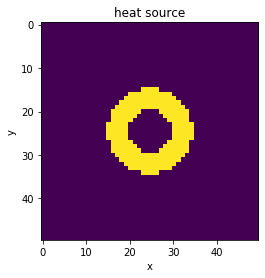

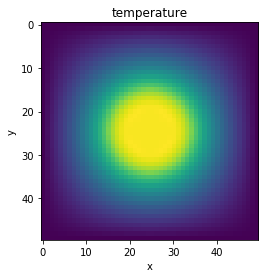

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot():
    
    nx = 50
    rho = np.zeros((nx, nx), dtype=np.float64)
    
    xx, yy = np.meshgrid(np.linspace(-1, 1, nx), np.linspace(-1, 1, nx))
    rho[:, :] = np.abs(np.sqrt(xx**2 + yy**2) - 0.3) < 0.1

    plt.figure()
    plt.imshow(rho)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("heat source")
    plt.show()

    n_iter=1000
            

    phi_numpy = np.zeros((nx, nx), dtype=np.float64)
    temperature_numpy(phi_numpy, rho, 1, 0.1, n_iter)
    
    plt.figure()
    plt.imshow(phi_numpy)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("temperature")
    plt.show()
    
    
    phi_numba = np.zeros((nx, nx), dtype=np.float64)
    temperature_numba(phi_numba, rho, 1, 0.1, n_iter)
        
    phi_numba_numpy = np.zeros((nx, nx), dtype=np.float64)
    temperature_numba_numpy(phi_numba_numpy, rho, 1, 0.1, n_iter)

    
    phi_cython_python = np.zeros((nx, nx), dtype=np.float64)
    temperature_cython_python(phi_cython_python, rho, 1, 0.1, n_iter)

    phi_cython_typed = np.zeros((nx, nx), dtype=np.float64)
    temperature_cython_typed(phi_cython_typed, rho, 1, 0.1, n_iter)

    phi_cython_optimized = np.zeros((nx, nx), dtype=np.float64)
    temperature_cython_optimized(phi_cython_optimized, rho, 1, 0.1, n_iter)

    phi_cython_c = np.zeros((nx, nx), dtype=np.float64)
    temperature_cython_c(phi_cython_c, rho, 1, 0.1, n_iter)
    
    #assert np.allclose(phi_numpy, phi_numpy)
    
    assert np.allclose(phi_numba, phi_numpy)
    assert np.allclose(phi_numba_numpy, phi_numpy)
    
    assert np.allclose(phi_cython_python, phi_numpy)
    assert np.allclose(phi_cython_typed, phi_numpy)
    assert np.allclose(phi_cython_optimized, phi_numpy)
    assert np.allclose(phi_cython_c, phi_numpy)

plot()

# Test speed

In [ ]:
def benchmark():
    
    rho = np.zeros((100, 100), dtype=np.float64)

    n_iter= 1000
       
    
    
    # python
    phi = np.zeros((100, 100), dtype=np.float64)
    %timeit temperature_python(phi, rho, 1, 0.1, n_iter//1000)
    

    # numpy
    phi = np.zeros((100, 100), dtype=np.float64)
    %timeit temperature_numpy(phi, rho, 1, 0.1, n_iter)
    
    
    
    # cython
    phi = np.zeros((100, 100), dtype=np.float64)
    %timeit temperature_cython_python(phi, rho, 1, 0.1, n_iter//1000)
    
    phi = np.zeros((100, 100), dtype=np.float64)
    %timeit temperature_cython_typed(phi, rho, 1, 0.1, n_iter)
    
    phi = np.zeros((100, 100), dtype=np.float64)
    %timeit temperature_cython_optimized(phi, rho, 1, 0.1, n_iter)
    
    phi = np.zeros((100, 100), dtype=np.float64)
    %timeit temperature_cython_c(phi, rho, 1, 0.1, n_iter)

    
    # numba
    # JIT compile
    phi = np.zeros((100, 100), dtype=np.float64)
    temperature_numba(phi, rho, 1, 0.1, 1)
    phi = np.zeros((100, 100), dtype=np.float64)
    temperature_numba_numpy(phi, rho, 1, 0.1, 1)
    
    phi = np.zeros((100, 100), dtype=np.float64)
    %timeit temperature_numba(phi, rho, 1, 0.1, n_iter)
    
    phi = np.zeros((100, 100), dtype=np.float64)
    %timeit temperature_numba_numpy(phi, rho, 1, 0.1, n_iter)
            
benchmark()